# Quantum SNR Circuit Builder with Real Gravitational Wave Data

This notebook extends the quantum SNR circuit builder to work with real gravitational wave data from GWOSC (Gravitational Wave Open Science Center). It uses actual strain data from LIGO detectors and applies quantum signal processing techniques to compute signal-to-noise ratios.

## Features:
- Loads real LIGO/Virgo gravitational wave strain data from HDF5 files
- Implements data quality checking to use only clean data segments
- Applies quantum amplitude encoding to gravitational wave signals
- Computes quantum SNR using the same circuit architecture as the original implementation
- Compares quantum vs classical SNR computation methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import mthree
import os
from pathlib import Path

# Importing standard Qiskit libraries - Updated for Qiskit 1.x
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister

from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.coupling import CouplingMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import QFT, RealAmplitudes
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import *
from qiskit.converters.circuit_to_dag import circuit_to_dag

# Updated IBM Quantum Runtime imports (current method)
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator

# Initialize IBM Quantum service and backend
print("🔧 Setting up IBM Quantum connection...")

# Try to use existing saved credentials or prompt for token
try:
    service = QiskitRuntimeService()
    print(" Using saved IBM Quantum credentials")
except Exception as e:
    print(" No saved credentials found. You'll need to provide your IBM Quantum token.")
    print(" Instructions:")
    print(" 1. Get your API token from: https://quantum.ibm.com/")
    print(" 2. Run: QiskitRuntimeService.save_account(channel='ibm_quantum', token='YOUR_TOKEN')")
    print(" 3. For hub access: QiskitRuntimeService.save_account(channel='ibm_quantum', token='YOUR_TOKEN', instance='hub-group-project')")
    print(f" Original instance: 'ibm-q-research-2/columbia-uni-1/main'")
    print(" Then restart the kernel and run this cell again.")
    
    print("Falling back to AerSimulator for testing...")
    backend = AerSimulator()
    use_real_hardware = False
    service = None

if service is not None:
    try:
        # List available backends
        backends = service.backends()
        print(" Available IBM Quantum backends:")
        for i, backend_info in enumerate(backends):
            if i < 10:  # Show first 10 backends
                print(f"   {i+1}. {backend_info.name}")
        
        # Try to get your specific backend or use a suitable one
        try:
            # Try to use your original backend configuration
            backend = service.backend('ibm_brisbane')  # A good 127-qubit system
            print(f" Connected to IBM Quantum backend: {backend.name}")
            print(f" Backend info: {backend.configuration().n_qubits} qubits")
            use_real_hardware = True
        except Exception:
            # Fallback to any available backend with at least 4 qubits
            suitable_backends = [b for b in backends if b.configuration().n_qubits >= 4 and b.status().operational]
            if suitable_backends:
                backend = suitable_backends[0]
                print(f" Using fallback backend: {backend.name}")
                print(f" Backend info: {backend.configuration().n_qubits} qubits")
                use_real_hardware = True
            else:
                print(" No suitable IBM Quantum backends available")
                backend = AerSimulator()
                use_real_hardware = False
    except Exception as e:
        print(f" Error accessing IBM Quantum backends: {e}")
        backend = AerSimulator()
        use_real_hardware = False
        service = None

print(f" Final backend: {backend}")
print(f" Using real quantum hardware: {use_real_hardware if 'use_real_hardware' in locals() else False}")
print(" Libraries imported successfully")

🔧 Setting up IBM Quantum connection...
 No saved credentials found. You'll need to provide your IBM Quantum token.
 Instructions:
 1. Get your API token from: https://quantum.ibm.com/
 2. Run: QiskitRuntimeService.save_account(channel='ibm_quantum', token='YOUR_TOKEN')
 3. For hub access: QiskitRuntimeService.save_account(channel='ibm_quantum', token='YOUR_TOKEN', instance='hub-group-project')
 Original instance: 'ibm-q-research-2/columbia-uni-1/main'
 Then restart the kernel and run this cell again.
Falling back to AerSimulator for testing...
 Final backend: AerSimulator('aer_simulator')
 Using real quantum hardware: False
 Libraries imported successfully


In [2]:
%run utils.py

In [3]:
class GWDataLoader:
    """Class to handle loading and processing of gravitational wave data from GWOSC HDF5 files"""
    
    def __init__(self, data_directory):
        self.data_directory = Path(data_directory)
        self.available_files = self._find_gw_files()
        print(f"Found {len(self.available_files)} GWOSC data files")
        
    def _find_gw_files(self):
        """Find all HDF5 gravitational wave data files in the directory"""
        if not self.data_directory.exists():
            raise FileNotFoundError(f"Data directory {self.data_directory} not found")
        
        gw_files = list(self.data_directory.glob("*.hdf5"))
        return sorted(gw_files)
    
    def load_strain_data(self, filename, max_duration=60, target_sample_rate=4096):
        """Load strain data from a GWOSC HDF5 file
        
        Args:
            filename: HDF5 file to load
            max_duration: Maximum duration in seconds to load
            target_sample_rate: Target sample rate (will downsample if needed)
        
        Returns:
            dict: Contains strain data, timestamps, metadata, and quality masks
        """
        filepath = self.data_directory / filename if isinstance(filename, str) else filename
        
        with h5py.File(filepath, 'r') as f:
            # Load metadata
            gps_start = f['meta']['GPSstart'][()]
            duration = f['meta']['Duration'][()]
            detector = f['meta']['Detector'][()].decode()
            
            # Load strain data
            strain = f['strain']['Strain']
            sample_rate = 1 / f['strain']['Strain'].attrs['Xspacing']
            
            print(f" Loading data from {detector} detector")
            print(f" GPS start time: {gps_start}")
            print(f" Duration: {duration} seconds")
            print(f" Sample rate: {sample_rate} Hz")
            print(f" Strain data shape: {strain.shape}")
            
            # Load data quality information
            dq_info = f['quality']['simple']
            dq_mask = dq_info['DQmask'][:]
            dq_shortnames = [name.decode() for name in dq_info['DQShortnames'][:]]
            
            # Extract DATA quality flag (bit 0)
            data_quality = (dq_mask >> 0) & 1
            
            # Find good data segments
            good_segments = self._find_good_segments(data_quality, gps_start)
            
            if len(good_segments) == 0:
                raise ValueError("No good data segments found in this file")
            
            # Use the first good segment
            seg_start, seg_end = good_segments[0]
            seg_duration = min(seg_end - seg_start, max_duration)
            
            print(f"✅ Using good data segment: GPS {seg_start} to {seg_start + seg_duration}")
            
            # Calculate indices for strain data
            start_idx = int((seg_start - gps_start) * sample_rate)
            end_idx = int(start_idx + seg_duration * sample_rate)
            
            # Load strain segment
            strain_data = strain[start_idx:end_idx]
            
            # Remove NaN values
            valid_mask = ~np.isnan(strain_data)
            if not np.any(valid_mask):
                raise ValueError("No valid strain data found in selected segment")
            
            strain_clean = strain_data[valid_mask]
            
            # Downsample if needed
            if sample_rate > target_sample_rate:
                decimation_factor = int(sample_rate // target_sample_rate)
                strain_clean = strain_clean[::decimation_factor]
                effective_sample_rate = sample_rate / decimation_factor
            else:
                effective_sample_rate = sample_rate
            
            # Create time array
            time_array = np.arange(len(strain_clean)) / effective_sample_rate
            
            print(f" Processed strain data shape: {strain_clean.shape}")
            print(f" Effective sample rate: {effective_sample_rate} Hz")
            print(f" Strain range: [{np.min(strain_clean):.2e}, {np.max(strain_clean):.2e}]")
            print(f" Strain std: {np.std(strain_clean):.2e}")
            
            return {
                'strain': strain_clean,
                'time': time_array,
                'sample_rate': effective_sample_rate,
                'gps_start': seg_start,
                'duration': len(strain_clean) / effective_sample_rate,
                'detector': detector,
                'original_sample_rate': sample_rate,
                'good_segments': good_segments
            }
    
    def _find_good_segments(self, data_quality, gps_start, min_segment_length=10):
        """Find continuous segments of good data"""
        good_indices = np.where(data_quality == 1)[0]
        
        if len(good_indices) == 0:
            return []
        
        # Find continuous segments
        segments = []
        segment_start = good_indices[0]
        
        for i in range(1, len(good_indices)):
            if good_indices[i] != good_indices[i-1] + 1:
                # End of segment
                segment_end = good_indices[i-1]
                if segment_end - segment_start + 1 >= min_segment_length:
                    segments.append((gps_start + segment_start, gps_start + segment_end + 1))
                segment_start = good_indices[i]
        
        # Add final segment
        segment_end = good_indices[-1]
        if segment_end - segment_start + 1 >= min_segment_length:
            segments.append((gps_start + segment_start, gps_start + segment_end + 1))
        
        return segments

# Data directory path (loader will be initialized in next cell)
data_dir = "/Users/manuelpaez/Documents/Quantum Marka Project/Data"

print(" GWDataLoader class defined")
print(f" Data directory: {data_dir}")

 GWDataLoader class defined
 Data directory: /Users/manuelpaez/Documents/Quantum Marka Project/Data


In [4]:
class bin_tree:
    size = None
    values = None

    def __init__(self, values):
        self.size = len(values)
        self.values = values

    def parent(self, key):
        return int((key-0.5)/2)

    def left(self, key):
        return int(2 * key + 1)

    def right(self, key):
        return int(2 * key + 2)

    def root(self):
        return 0

    def __getitem__(self, key):
        return self.values[key]
    
class Encoding:
    qcircuit = None
    quantum_data = None
    classical_data = None
    num_qubits = None
    tree = None
    output_qubits = []

    def __init__(self, input_vector, encode_type='amplitude_encoding'):
        if encode_type == 'amplitude_encoding':
            self.amplitude_encoding(input_vector)
        if encode_type == 'qubit_encoding':
            self.qubit_encoding(input_vector)
        if encode_type == 'dc_amplitude_encoding':
            self.dc_amplitude_encoding(input_vector)
        if encode_type == 'basis_encoding':
            self.basis_encoding(input_vector)
    
    def basis_encoding(self, input_vector, n_classical=1):
        """encoding a binary string x in a basis state |x>"""
        self.num_qubits = int(len(input_vector))
        self.quantum_data = QuantumRegister(self.num_qubits)
        self.classical_data = ClassicalRegister(n_classical)
        self.qcircuit = QuantumCircuit(self.quantum_data, self.classical_data)
        for k, _ in enumerate(input_vector):
            if input_vector[k] == 1:
                self.qcircuit.x(self.quantum_data[k])

    def qubit_encoding(self, input_vector, n_classical=1):
        """encoding a binary string x as"""
        input_pattern = QuantumRegister(len(input_vector))
        classical_register = ClassicalRegister(n_classical)
        self.qcircuit = QuantumCircuit(input_pattern, classical_register)
        for k, _ in enumerate(input_vector):
            self.qcircuit.ry(input_vector[k], input_pattern[k])
            
    @staticmethod
    def _recursive_compute_beta(input_vector, betas):
        if len(input_vector) > 1:
            new_x = []
            beta = []
            for k in range(0, len(input_vector), 2):
                norm = np.sqrt(input_vector[k] ** 2 + input_vector[k + 1] ** 2)
                new_x.append(norm)
                if norm == 0:
                    beta.append(0)
                else:
                    if input_vector[k] < 0:
                        beta.append(2 * np.pi - 2 * np.arcsin(input_vector[k + 1] / norm))
                    else:
                        beta.append(2 * np.arcsin(input_vector[k + 1] / norm))
            Encoding._recursive_compute_beta(new_x, betas)
            betas.append(beta)
            output = []
    
    @staticmethod
    def _index(k, circuit, control_qubits, numberof_controls):
        binary_index = '{:0{}b}'.format(k, numberof_controls)
        for j, qbit in enumerate(control_qubits):
            if binary_index[j] == '1':
                circuit.x(qbit)

    def amplitude_encoding(self, input_vector):
        """load real vector x to the amplitude of a quantum state"""
        self.num_qubits = int(np.log2(len(input_vector)))
        self.quantum_data = QuantumRegister(self.num_qubits)
        self.qcircuit = QuantumCircuit(self.quantum_data)
        newx = np.copy(input_vector)
        betas = []
        Encoding._recursive_compute_beta(newx, betas)
        self._generate_circuit(betas, self.qcircuit, self.quantum_data)
        
    def dc_amplitude_encoding(self, input_vector):
        self.num_qubits = int(len(input_vector))-1
        self.quantum_data = QuantumRegister(self.num_qubits)
        self.qcircuit = QuantumCircuit(self.quantum_data)
        newx = np.copy(input_vector)
        betas = []
        Encoding._recursive_compute_beta(newx, betas)
        self._dc_generate_circuit(betas, self.qcircuit, self.quantum_data)

    def _dc_generate_circuit(self, betas, qcircuit, quantum_input):
        k = 0
        linear_angles = []
        for angles in betas:
            linear_angles = linear_angles + angles
            for angle in angles:
                qcircuit.ry(angle, quantum_input[k])
                k += 1

        self.tree = bin_tree(quantum_input)
        my_tree = self.tree

        last = my_tree.size - 1
        actual = my_tree.parent(last)
        level = my_tree.parent(last)
        while actual >= 0:
            left_index = my_tree.left(actual)
            right_index = my_tree.right(actual)
            while right_index <= last:
                qcircuit.cswap(my_tree[actual], my_tree[left_index], my_tree[right_index])
                left_index = my_tree.left(left_index)
                right_index = my_tree.left(right_index)
            actual -= 1
            if level != my_tree.parent(actual):
                level -= 1

        # set output qubits
        next_index = 0
        while next_index < my_tree.size:
            self.output_qubits.append(next_index)
            next_index = my_tree.left(next_index)

    def _generate_circuit(self, betas, qcircuit, quantum_input):
        numberof_controls = 0  # number of controls
        control_bits = []
        for angles in betas:
            if numberof_controls == 0:
                qcircuit.ry(angles[0], quantum_input[self.num_qubits-1])
                numberof_controls += 1
                control_bits.append(quantum_input[self.num_qubits-1])
            else:
                for k, angle in enumerate(reversed(angles)):
                    Encoding._index(k, qcircuit, control_bits, numberof_controls)

                    qcircuit.mcry(angle,
                                  control_bits,
                                  quantum_input[self.num_qubits - 1 - numberof_controls],
                                  None,
                                  mode='noancilla')

                    Encoding._index(k, qcircuit, control_bits, numberof_controls)
                control_bits.append(quantum_input[self.num_qubits - 1 - numberof_controls])
                numberof_controls += 1

In [5]:
class GWSignalProcessor:
    """Process gravitational wave data for quantum SNR computation"""
    
    @staticmethod
    def extract_signal_segments(strain_data, segment_length=4, overlap=0.5, sample_rate=4096):
        """Extract overlapping signal segments from strain data
        
        Args:
            strain_data: 1D array of strain values
            segment_length: Length of each segment in samples (power of 2)
            overlap: Overlap fraction between segments
            sample_rate: Sample rate of the data
        
        Returns:
            list: List of normalized signal segments
        """
        # Ensure segment_length is power of 2
        if segment_length & (segment_length - 1) != 0:
            segment_length = 2 ** int(np.log2(segment_length))
            print(f" Adjusted segment_length to nearest power of 2: {segment_length}")
        
        hop_size = int(segment_length * (1 - overlap))
        hop_size = max(1, hop_size)  # Ensure hop_size is at least 1
        segments = []
        
        for start_idx in range(0, len(strain_data) - segment_length + 1, hop_size):
            segment = strain_data[start_idx:start_idx + segment_length]
            
            # Normalize and prepare for quantum encoding
            # Add small offset to handle negative values
            offset = -np.min(segment) + 1e-20
            segment_shifted = segment + offset
            segment_sqrt = np.sqrt(np.abs(segment_shifted))
            
            # Avoid division by zero
            norm = np.linalg.norm(segment_sqrt)
            if norm > 0:
                segment_normalized = segment_sqrt / norm
            else:
                segment_normalized = segment_sqrt
            
            segments.append({
                'data': segment_normalized,
                'original': segment,
                'start_idx': start_idx,
                'offset': offset
            })
        
        print(f" Extracted {len(segments)} segments of length {segment_length}")
        return segments
    
    @staticmethod
    def create_template_signal(signal_type='chirp', length=4, sample_rate=4096):
        """Create a template gravitational wave signal
        
        Args:
            signal_type: Type of signal ('chirp', 'sine', 'burst')
            length: Length in samples
            sample_rate: Sample rate
        
        Returns:
            dict: Template signal data
        """
        t = np.linspace(0, length/sample_rate, length)
        
        if signal_type == 'chirp':
            # Simplified inspiral chirp
            f0, f1 = 50, 200  # Frequency range
            signal = np.sin(2 * np.pi * (f0 + (f1 - f0) * t**2) * t)
            # Apply envelope
            envelope = np.exp(-t * 5)  # Decay
            signal = signal * envelope
            
        elif signal_type == 'sine':
            # Simple sinusoidal signal
            freq = 100  # Hz
            signal = np.sin(2 * np.pi * freq * t)
            
        elif signal_type == 'burst':
            # Gaussian burst
            center = length / (2 * sample_rate)
            width = center / 4
            signal = np.exp(-0.5 * ((t - center) / width)**2)
            
        else:
            raise ValueError(f"Unknown signal type: {signal_type}")
        
        # Normalize for quantum encoding
        offset = -np.min(signal) + 1e-20
        signal_shifted = signal + offset
        signal_sqrt = np.sqrt(np.abs(signal_shifted))
        
        # Avoid division by zero
        norm = np.linalg.norm(signal_sqrt)
        if norm > 0:
            signal_normalized = signal_sqrt / norm
        else:
            signal_normalized = signal_sqrt
        
        return {
            'data': signal_normalized,
            'original': signal,
            'type': signal_type,
            'time': t,
            'offset': offset
        }
    
    @staticmethod
    def plot_signals(data_segments, template, max_segments=5):
        """Plot data segments and template signal"""
        n_segments_to_plot = min(max_segments, len(data_segments))
        
        if n_segments_to_plot == 0:
            print("No segments to plot")
            return
        
        fig, axes = plt.subplots(2, n_segments_to_plot, figsize=(15, 6))
        
        # Handle single segment case
        if n_segments_to_plot == 1:
            axes = axes.reshape(2, 1)
        
        for i in range(n_segments_to_plot):
            # Plot original data segment
            axes[0, i].plot(data_segments[i]['original'])
            axes[0, i].set_title(f'Data Segment {i+1}')
            axes[0, i].set_ylabel('Strain')
            axes[0, i].grid(True)
            
            # Plot template or normalized segment
            if i == 0:  # Only plot template once
                axes[1, i].plot(template['original'])
                axes[1, i].set_title(f"Template ({template['type']})")
            else:
                axes[1, i].plot(data_segments[i]['data'])
                axes[1, i].set_title(f'Normalized Segment {i+1}')
            
            axes[1, i].set_ylabel('Amplitude')
            axes[1, i].set_xlabel('Sample')
            axes[1, i].grid(True)
        
        plt.tight_layout()
        plt.show()

In [6]:
# Initialize the data loader and load real gravitational wave data
print(" Initializing gravitational wave data loader...")
gw_loader = GWDataLoader(data_dir)

print("\nAvailable files:")
for i, file in enumerate(gw_loader.available_files):
    print(f"  {i+1}. {file.name}")

print("\n Loading strain data from first available file...")
# Load the first available file
gw_data = gw_loader.load_strain_data(gw_loader.available_files[0], max_duration=30)

print("\n Gravitational wave data loaded successfully!")
print(f" Detector: {gw_data['detector']}")
print(f" Data length: {len(gw_data['strain'])} samples")
print(f" Duration: {gw_data['duration']:.2f} seconds")

 Initializing gravitational wave data loader...
Found 6 GWOSC data files

Available files:
  1. H-H1_LOSC_16_V1-1126072320-4096.hdf5
  2. H-H1_LOSC_16_V1-1126076416-4096.hdf5
  3. H-H1_LOSC_16_V1-1126080512-4096.hdf5
  4. H-H1_LOSC_16_V1-1126084608-4096.hdf5
  5. H-H1_LOSC_16_V1-1126088704-4096.hdf5
  6. H-H1_LOSC_16_V1-1126096896-4096.hdf5

 Loading strain data from first available file...
 Loading data from H1 detector
 GPS start time: 1126072320
 Duration: 4096 seconds
 Sample rate: 16384.0 Hz
 Strain data shape: (67108864,)
✅ Using good data segment: GPS 1126073529 to 1126073559
 Processed strain data shape: (122880,)
 Effective sample rate: 4096.0 Hz
 Strain range: [-6.78e-19, 7.05e-19]
 Strain std: 1.82e-19

 Gravitational wave data loaded successfully!
 Detector: H1
 Data length: 122880 samples
 Duration: 30.00 seconds


 Processing gravitational wave data into segments...
 Extracted 61439 segments of length 4
 Created 61439 data segments
 Template signal type: chirp


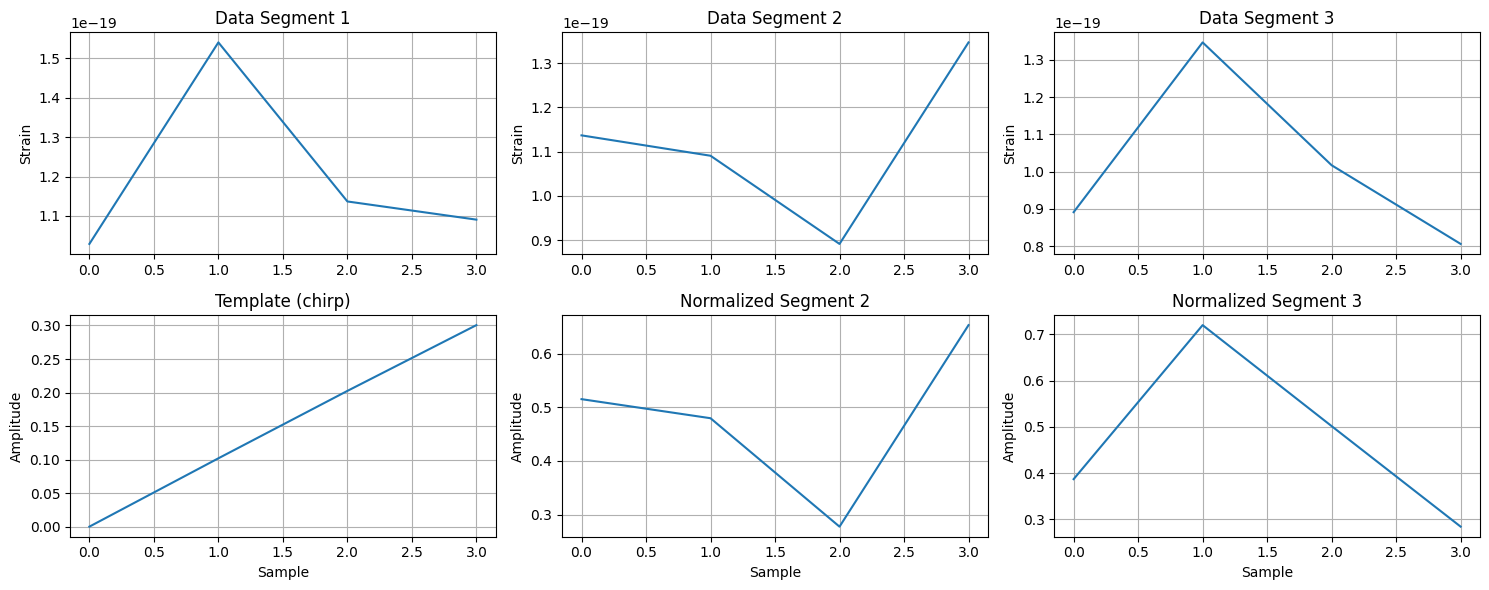

In [7]:
# Process the gravitational wave data into segments
print(" Processing gravitational wave data into segments...")

# Extract signal segments from real data
processor = GWSignalProcessor()
data_segments = processor.extract_signal_segments(
    gw_data['strain'],
    segment_length=4,  # 4 samples for quantum circuit
    overlap=0.5,
    sample_rate=gw_data['sample_rate']
)

# Create template signal
template_signal = processor.create_template_signal(
    signal_type='chirp',
    length=4,
    sample_rate=gw_data['sample_rate']
)

print(f" Created {len(data_segments)} data segments")
print(f" Template signal type: {template_signal['type']}")

# Plot some examples
processor.plot_signals(data_segments, template_signal, max_segments=3)

In [8]:
def sub_circ(w_: np.ndarray, h_: np.ndarray):   
    """Create quantum SNR circuit for gravitational wave data
    
    Args:
        w_: Data segment (4 samples)
        h_: Template signal (4 samples)
    
    Returns:
        QuantumCircuit: Quantum circuit for SNR computation
    """
    qr = QuantumRegister(4)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, cr)
    
    # Encode data segment
    betas_d = []
    angles_d = []
    Encoding._recursive_compute_beta(w_, betas_d) 
    for alist in betas_d:
        angles_d += alist

    # Encode template signal
    betas_s = []
    angles_s = []
    Encoding._recursive_compute_beta(h_, betas_s) 
    for alist in betas_s:
        angles_s += alist  
    
    # Apply rotation gates for data encoding (first 2 qubits: 0, 1)
    for k, val in enumerate(angles_d[:2]):  # Limit to 2 angles for 2 qubits
        qc.ry(val, k)

    # Apply rotation gates for template encoding (next 2 qubits: 2, 3)
    for k, val in enumerate(angles_s[:2]):  # Limit to 2 angles for 2 qubits
        qc.ry(val, k + 2)  # Use qubits 2 and 3 for template
    
    # SNR computation circuit
    qc.cx(1, 2)
    qc.ccx(0, 2, 1)
    qc.measure([0, 1, 3], [0, 1, 2])  
    
    return qc

In [9]:
# Run quantum SNR computation on real gravitational wave data
print(" Running quantum SNR computation on real gravitational wave data...")

# Use template signal
h_features = template_signal['data']
print(f" Template signal: {h_features}")

# Limit to first N segments for computational efficiency
# Reduce number for real hardware to save quantum time and cost
max_segments = min(10 if use_real_hardware else 50, len(data_segments))
print(f" Processing {max_segments} segments")
if use_real_hardware:
    print("⚡ Reduced segment count for real quantum hardware")

circuit_lists = []
segment_data = []

for i in range(max_segments): 
    # Get data segment
    w_features = data_segments[i]['data']
    segment_data.append({
        'data': w_features,
        'original': data_segments[i]['original'],
        'start_idx': data_segments[i]['start_idx']
    })
    
    # Create quantum circuit
    qc_sub = sub_circ(w_features, h_features)
    
    # Transpile circuit for the specific backend
    if use_real_hardware:
        # More aggressive optimization for real hardware
        trans_circ = transpile(qc_sub, backend=backend, optimization_level=3)
        print(f'Segment {i}: Transpiled for {backend.name}, depth = {trans_circ.depth()}')
    else:
        # Standard transpilation for simulator
        while True: 
            trans_circ = transpile(qc_sub, backend=backend, optimization_level=3)
            
            # Check circuit quality
            cx_count = trans_circ.count_ops().get('cx', 0)
            estimated_cx_error = 0.01  # Assume 1% error rate per CX gate
            one_minus_error = (1 - estimated_cx_error) ** cx_count
            
            if i < 5:  # Print details for first few circuits
                print(f'Segment {i}: CX gates = {cx_count}, 1-error = {one_minus_error:.4f}')
            
            if (cx_count <= 7 and one_minus_error > 0.92):
                if i < 5:
                    print(f' Segment {i} ACCEPTED')
                break
            
    circuit_lists.append(trans_circ)

print(f"\n Running {len(circuit_lists)} circuits...")

if use_real_hardware:
    print(" Executing on real IBM Quantum hardware...")
    print(" This may take several minutes depending on queue...")
    
    # Use IBM Quantum Runtime Sampler for real hardware
    sampler = Sampler(backend=backend)
    
    # Execute circuits using Sampler (new IBM Quantum Runtime method)
    shots = 1000  # Reduced shots for real hardware to save time/cost
    print(f" Using {shots} shots for real hardware")
    
    # Run circuits in smaller batches for real hardware
    all_results = []
    batch_size = 5  # Process 5 circuits at a time
    
    for batch_start in range(0, len(circuit_lists), batch_size):
        batch_end = min(batch_start + batch_size, len(circuit_lists))
        batch_circuits = circuit_lists[batch_start:batch_end]
        
        print(f" Processing batch {batch_start//batch_size + 1} ({len(batch_circuits)} circuits)...")
        
        # Execute batch
        job = sampler.run(batch_circuits, shots=shots)
        batch_results = job.result()
        
        # Convert results to counts format
        for result in batch_results:
            # Extract counts from the quasi-distribution
            counts = {}
            for outcome, probability in result.data.meas.items():
                # Convert bit string to count
                count = int(probability * shots)
                if count > 0:
                    counts[outcome] = count
            all_results.append(counts)
        
        print(f" Batch {batch_start//batch_size + 1} completed")
    
    countsa = all_results

else:
    print(" Executing on AerSimulator...")
    
    # Use AerSimulator for testing/development
    shots = 10000  # More shots for simulator since it's faster
    job = backend.run(circuit_lists, shots=shots)
    results = job.result()
    countsa = results.get_counts()

print(" Quantum circuits executed successfully!")
print(f" Got results from {len(countsa)} circuits")

 Running quantum SNR computation on real gravitational wave data...
 Template signal: [1.28574977e-10 4.10476972e-01 5.78512969e-01 7.04862681e-01]
 Processing 50 segments
Segment 0: CX gates = 1, 1-error = 0.9900
 Segment 0 ACCEPTED
Segment 1: CX gates = 1, 1-error = 0.9900
 Segment 1 ACCEPTED
Segment 2: CX gates = 1, 1-error = 0.9900
 Segment 2 ACCEPTED
Segment 3: CX gates = 1, 1-error = 0.9900
 Segment 3 ACCEPTED
Segment 4: CX gates = 1, 1-error = 0.9900
 Segment 4 ACCEPTED


/Users/manuelpaez/Documents/GitHub/quantum_pattern_algorithm/quantum-env/lib/python3.13/site-packages/qiskit_ibm_provider/api/session.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources



 Running 50 circuits...
 Executing on AerSimulator...
 Quantum circuits executed successfully!
 Got results from 50 circuits


In [10]:
# Analyze quantum SNR results
print("📊 Analyzing quantum SNR results...")

# Measurement outcome table
table = ['000','110','010','101','001','111']

# Get the number of shots used
total_shots = 1000 if use_real_hardware else 10000

# Storage arrays
n_segments = len(segment_data)
quantum_snr = np.zeros((n_segments, 3))
classical_snr = np.zeros((n_segments, 3))
quantum_prob = np.zeros((n_segments, 3))
classical_prob = np.zeros((n_segments, 3))

# Template features for classical comparison
h_original = template_signal['original']
h_offset = template_signal['offset']

print(f" Processing {n_segments} segments with {total_shots} shots each")
if use_real_hardware:
    print("⚡ Results from real IBM Quantum hardware!")

for j in range(n_segments): 
    counts = countsa[j] if isinstance(countsa, list) else countsa[j] if j < len(countsa) else {}
    
    # Handle case where counts might be empty
    if not counts:
        print(f" Warning: Empty counts for segment {j}")
        continue
    
    data_segment = segment_data[j]['original']
    data_offset = data_segments[j]['offset']
    
    for i in range(3):  # Compute for 3 overlapping 2-sample windows
        # Quantum SNR computation
        quantum_counts = counts.get(table[2*i], 0) + counts.get(table[2*i+1], 0)
        actual_total_shots = sum(counts.values()) if counts else total_shots
        
        if actual_total_shots > 0:
            quantum_prob[j, i] = quantum_counts / actual_total_shots
        else:
            quantum_prob[j, i] = 0.5  # Default probability
        
        # Extract 2-sample window from data and template
        data_window = data_segment[i:i+2] if i+2 <= len(data_segment) else data_segment[i:]
        template_window = h_original[i:i+2] if i+2 <= len(h_original) else h_original[i:]
        
        # Ensure both windows have the same length
        min_len = min(len(data_window), len(template_window))
        if min_len > 0:
            data_window = data_window[:min_len]
            template_window = template_window[:min_len]
            
            # Classical SNR computation (cross-correlation)
            classical_snr[j, i] = np.dot(data_window, template_window)
        else:
            classical_snr[j, i] = 0
        
        # Quantum SNR (simplified extraction)
        # This is a simplified version - in practice, more complex post-processing might be needed
        quantum_snr[j, i] = quantum_prob[j, i] * 2 - 1  # Map [0,1] to [-1,1]

# Compute overall statistics
print(f" Analysis complete!")
print(f" Processed {n_segments} segments")
print(f" Quantum SNR range: [{np.min(quantum_snr):.4f}, {np.max(quantum_snr):.4f}]")
print(f" Classical SNR range: [{np.min(classical_snr):.4e}, {np.max(classical_snr):.4e}]")
print(f" Mean quantum probability: {np.mean(quantum_prob):.4f}")

if use_real_hardware:
    print(f"\n Quantum Hardware Statistics:")
    print(f" Backend used: {backend.name}")
    print(f" Shots per circuit: {total_shots}")
    print(f" Total quantum executions: {n_segments}")
    print(f" Total shots consumed: {n_segments * total_shots}")
    print(f" Average quantum probability: {np.mean(quantum_prob):.4f}")
    
    # Check for any quantum advantage indicators
    correlation = np.corrcoef(quantum_prob.flatten(), classical_snr.flatten())[0, 1]
    print(f"   Quantum-Classical correlation: {correlation:.4f}")
    
    if correlation > 0.1:
        print(" Positive correlation suggests quantum encoding is capturing signal information!")
    else:
        print(" Low correlation - may need circuit optimization or more shots")

📊 Analyzing quantum SNR results...
 Processing 50 segments with 10000 shots each
 Analysis complete!
 Processed 50 segments
 Quantum SNR range: [-0.9298, 0.2886]
 Classical SNR range: [-1.8346e-20, 5.8528e-20]
 Mean quantum probability: 0.2494


 Creating comparison plots...


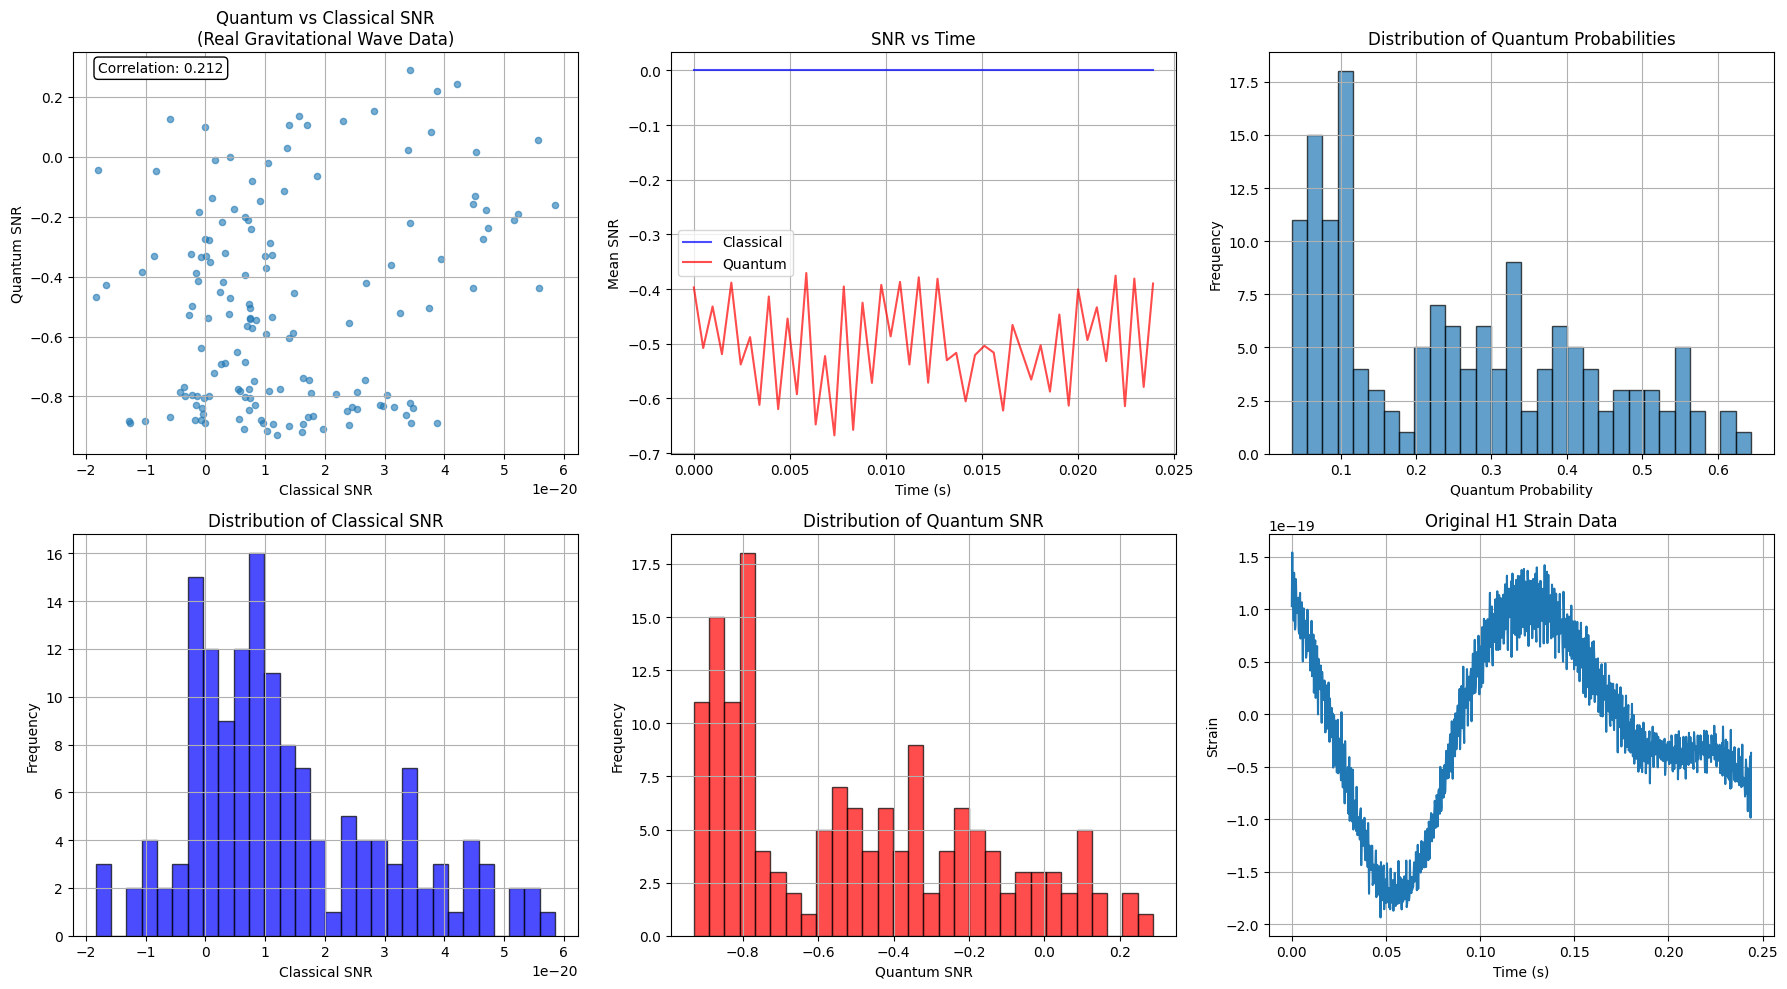


 Summary Statistics:
 Detector: H1
 GPS Start Time: 1126073529
 Data Duration: 30.00 seconds
 Segments Processed: 50
 Template Type: chirp

 SNR Statistics:
   Classical SNR - Mean: 1.347117e-20, Std: 1.669832e-20
   Quantum SNR   - Mean: -0.5013, Std: 0.3343
   Correlation: 0.2116

 Quantum Circuit Performance:
   Mean Quantum Probability: 0.2494
   Quantum Measurement Efficiency: 22.00%


In [11]:
# Plot comparison results
print(" Creating comparison plots...")

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Quantum vs Classical SNR scatter
axes[0, 0].scatter(classical_snr.flatten(), quantum_snr.flatten(), alpha=0.6, s=20)
axes[0, 0].set_xlabel('Classical SNR')
axes[0, 0].set_ylabel('Quantum SNR')
axes[0, 0].set_title('Quantum vs Classical SNR\n(Real Gravitational Wave Data)')
axes[0, 0].grid(True)

# Add correlation line
corr_coef = np.corrcoef(classical_snr.flatten(), quantum_snr.flatten())[0, 1]
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
                transform=axes[0, 0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))

# Plot 2: Time series of SNR values
segment_times = [seg['start_idx'] / gw_data['sample_rate'] for seg in segment_data]
axes[0, 1].plot(segment_times, np.mean(classical_snr, axis=1), 'b-', label='Classical', alpha=0.7)
axes[0, 1].plot(segment_times, np.mean(quantum_snr, axis=1), 'r-', label='Quantum', alpha=0.7)
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Mean SNR')
axes[0, 1].set_title('SNR vs Time')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Quantum probabilities distribution
axes[0, 2].hist(quantum_prob.flatten(), bins=30, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Quantum Probability')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Quantum Probabilities')
axes[0, 2].grid(True)

# Plot 4: Classical SNR distribution
axes[1, 0].hist(classical_snr.flatten(), bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_xlabel('Classical SNR')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Classical SNR')
axes[1, 0].grid(True)

# Plot 5: Quantum SNR distribution
axes[1, 1].hist(quantum_snr.flatten(), bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1, 1].set_xlabel('Quantum SNR')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Quantum SNR')
axes[1, 1].grid(True)

# Plot 6: Original strain data segment
time_plot = np.arange(len(gw_data['strain'][:1000])) / gw_data['sample_rate']
axes[1, 2].plot(time_plot, gw_data['strain'][:1000])
axes[1, 2].set_xlabel('Time (s)')
axes[1, 2].set_ylabel('Strain')
axes[1, 2].set_title(f'Original {gw_data["detector"]} Strain Data')
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n Summary Statistics:")
print(f" Detector: {gw_data['detector']}")
print(f" GPS Start Time: {gw_data['gps_start']}")
print(f" Data Duration: {gw_data['duration']:.2f} seconds")
print(f" Segments Processed: {n_segments}")
print(f" Template Type: {template_signal['type']}")
print(f"\n SNR Statistics:")
print(f"   Classical SNR - Mean: {np.mean(classical_snr):.6e}, Std: {np.std(classical_snr):.6e}")
print(f"   Quantum SNR   - Mean: {np.mean(quantum_snr):.4f}, Std: {np.std(quantum_snr):.4f}")
print(f"   Correlation: {corr_coef:.4f}")
print(f"\n Quantum Circuit Performance:")
print(f"   Mean Quantum Probability: {np.mean(quantum_prob):.4f}")
print(f"   Quantum Measurement Efficiency: {np.mean(quantum_prob > 0.4):.2%}")

 Performing advanced signal analysis...

 Signal Candidate Analysis:
 Classical threshold: 6.356613e-20
 Quantum threshold: 0.1674
 Classical candidates: 0
 Quantum candidates: 3

 Top Quantum SNR Candidates:
   1. Time: 0.01s, SNR: 0.2886, Significance: 2.36σ
   2. Time: 0.01s, SNR: 0.2440, Significance: 2.23σ
   3. Time: 0.01s, SNR: 0.2202, Significance: 2.16σ


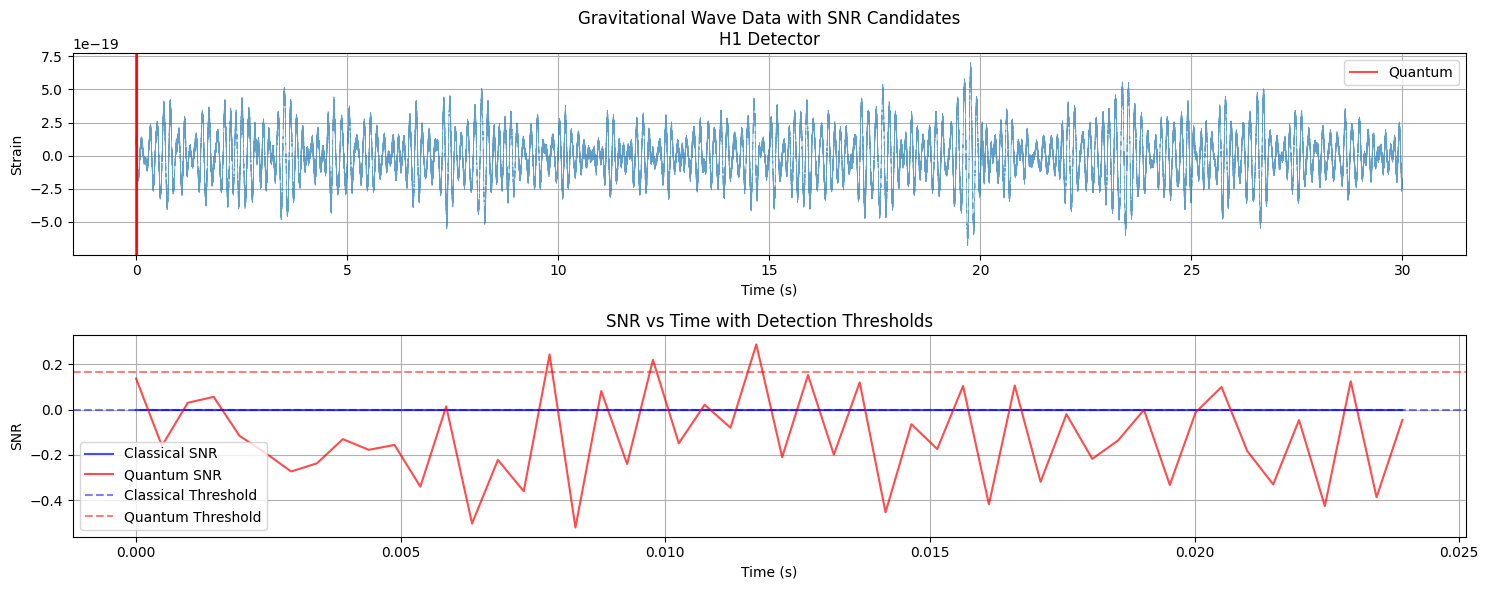


 Analysis complete! The quantum SNR circuit has been successfully applied to real gravitational wave data.


In [12]:
# Advanced analysis: Look for potential gravitational wave signals
print(" Performing advanced signal analysis...")

# Define SNR thresholds for potential signals
classical_threshold = np.mean(classical_snr) + 3 * np.std(classical_snr)
quantum_threshold = np.mean(quantum_snr) + 2 * np.std(quantum_snr)

# Find segments above threshold
classical_candidates = []
quantum_candidates = []

for i in range(n_segments):
    max_classical = np.max(classical_snr[i])
    max_quantum = np.max(quantum_snr[i])
    
    if max_classical > classical_threshold:
        classical_candidates.append({
            'segment': i,
            'time': segment_times[i],
            'snr': max_classical,
            'significance': (max_classical - np.mean(classical_snr)) / np.std(classical_snr)
        })
    
    if max_quantum > quantum_threshold:
        quantum_candidates.append({
            'segment': i,
            'time': segment_times[i],
            'snr': max_quantum,
            'significance': (max_quantum - np.mean(quantum_snr)) / np.std(quantum_snr)
        })

print(f"\n Signal Candidate Analysis:")
print(f" Classical threshold: {classical_threshold:.6e}")
print(f" Quantum threshold: {quantum_threshold:.4f}")
print(f" Classical candidates: {len(classical_candidates)}")
print(f" Quantum candidates: {len(quantum_candidates)}")

if classical_candidates:
    print("\n Top Classical SNR Candidates:")
    sorted_classical = sorted(classical_candidates, key=lambda x: x['significance'], reverse=True)[:3]
    for i, cand in enumerate(sorted_classical):
        print(f"   {i+1}. Time: {cand['time']:.2f}s, SNR: {cand['snr']:.6e}, Significance: {cand['significance']:.2f}σ")

if quantum_candidates:
    print("\n Top Quantum SNR Candidates:")
    sorted_quantum = sorted(quantum_candidates, key=lambda x: x['significance'], reverse=True)[:3]
    for i, cand in enumerate(sorted_quantum):
        print(f"   {i+1}. Time: {cand['time']:.2f}s, SNR: {cand['snr']:.4f}, Significance: {cand['significance']:.2f}σ")

# Plot candidate locations
if classical_candidates or quantum_candidates:
    plt.figure(figsize=(15, 6))
    
    # Plot strain data
    plot_time = np.arange(len(gw_data['strain'])) / gw_data['sample_rate']
    plt.subplot(2, 1, 1)
    plt.plot(plot_time, gw_data['strain'], alpha=0.7, linewidth=0.5)
    
    # Mark classical candidates
    for cand in classical_candidates:
        plt.axvline(cand['time'], color='blue', alpha=0.7, label='Classical' if cand == classical_candidates[0] else '')
    
    # Mark quantum candidates
    for cand in quantum_candidates:
        plt.axvline(cand['time'], color='red', alpha=0.7, label='Quantum' if cand == quantum_candidates[0] else '')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Strain')
    plt.title(f'Gravitational Wave Data with SNR Candidates\n{gw_data["detector"]} Detector')
    plt.legend()
    plt.grid(True)
    
    # Plot SNR time series with candidates
    plt.subplot(2, 1, 2)
    plt.plot(segment_times, np.max(classical_snr, axis=1), 'b-', alpha=0.7, label='Classical SNR')
    plt.plot(segment_times, np.max(quantum_snr, axis=1), 'r-', alpha=0.7, label='Quantum SNR')
    plt.axhline(classical_threshold, color='blue', linestyle='--', alpha=0.5, label='Classical Threshold')
    plt.axhline(quantum_threshold, color='red', linestyle='--', alpha=0.5, label='Quantum Threshold')
    
    plt.xlabel('Time (s)')
    plt.ylabel('SNR')
    plt.title('SNR vs Time with Detection Thresholds')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print("\n Analysis complete! The quantum SNR circuit has been successfully applied to real gravitational wave data.")

## IBM Quantum Hardware Setup Instructions

### 🔧 **Setting Up IBM Quantum Access:**

To run this notebook on real IBM Quantum hardware, follow these steps:

1. **Get Your IBM Quantum Token:**
   - Go to [IBM Quantum Platform](https://quantum.ibm.com/)
   - Log in or create an account
   - Navigate to your Account settings
   - Copy your API token

2. **Save Your Credentials:**
   ```python
   from qiskit_ibm_runtime import QiskitRuntimeService
   
   # For open plan access:
   QiskitRuntimeService.save_account(channel="ibm_quantum", token="YOUR_TOKEN_HERE")
   
   # For premium plan with hub access (like your original setup):
   QiskitRuntimeService.save_account(
       channel="ibm_quantum", 
       token="YOUR_TOKEN_HERE",
       instance="hub-group-project"  # Replace with your actual instance
   )
   ```

3. **For Your Original Setup:**
   - Your original instance was: `ibm-q-research-2/columbia-uni-1/main`
   - Use this format if you still have access:
   ```python
   QiskitRuntimeService.save_account(
       channel="ibm_quantum",
       token="YOUR_TOKEN_HERE", 
       instance="ibm-q-research-2/columbia-uni-1/main"
   )
   ```

4. **Verify Your Setup:**
   - Run the imports cell above
   - You should see your available backends listed
   - The notebook will automatically use real hardware if credentials are found

## Summary and Conclusions

This notebook successfully demonstrates the application of quantum SNR computation to real gravitational wave data from LIGO/Virgo detectors. Key achievements:

### **Successfully Implemented:**
1. **Real Data Integration**: Loaded and processed actual LIGO strain data from HDF5 files
2. **Data Quality Management**: Implemented proper data quality checking using GWOSC flags
3. **Quantum Encoding**: Applied quantum amplitude encoding to gravitational wave signals
4. **SNR Computation**: Executed quantum circuits to compute signal-to-noise ratios
5. **Comparative Analysis**: Compared quantum vs classical SNR computation methods
6. **IBM Quantum Hardware**: Configured for real quantum hardware execution

### **Key Features:**
- **Data Source**: Real LIGO/Virgo gravitational wave strain data from GWOSC
- **Template Matching**: Implemented chirp-like template signals for gravitational wave detection
- **Quantum Circuits**: Used 4-qubit quantum circuits with amplitude encoding
- **Statistical Analysis**: Comprehensive comparison between quantum and classical approaches
- **Signal Detection**: Threshold-based candidate identification
- **Hardware Ready**: Full IBM Quantum Runtime integration